# Домашнее задание к занятию «Сингулярный спектральный анализ»
Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.

In [1]:
# Загружаем необходимые библиотеки
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Загружаем временной ряд
series = pd.read_csv('international-airline-passengers.csv')['Count']

In [3]:
# Воспользуемся классом SSA, приведенному в материалах занятия
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Разлагает заданный временной ряд с помощью анализа сингулярного спектра. Предполагается, что значения 
        временного ряда записываются через равные промежутки времени.
        
        Параметры
        ----------
        tseries : Исходный временной ряд в виде серии Pandas, массива NumPy или списка. 
        L : Длина окна. Должно быть целое число 2 <= L <= N/2, где N - длина временного ряда.
        save_mem : Экономит память, не сохраняя элементарные матрицы. Рекомендуется для длинных временных рядов с
        тысячами значений. По умолчанию имеет значение True.
        
        Note: Даже если для исходного временного ряда используется массив или список NumPy, все возвращаемые 
        временные ряды будут в форме объекта Pandas Series или DataFrame.
        """
        
        # Проверка типов для исходного временного ряда
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Неподдерживаемый объект временного ряда. Попробуйте использовать Pandas Series, массив или список NumPy.")
        
        # Проверка длины окна
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("Длина окна должна находиться в интервале [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Преобразование временного ряда в матрицу траекторий
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Разложение матрицы траекторий
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Построение и сохранение элементарных матриц
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Диагональное усреднение элементарных матриц, сохранение их в виде столбцов в массиве.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Восстановление элементарных матриц без их сохранения
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Повторный запуск с save_mem=False для сохранения элементарных матриц."
            
            # Массив V также может быть очень большим при таких обстоятельствах, поэтому мы не будем его сохранять.
            self.V = "Повторный запуск с save_mem=False для сохранения матрицы V."
        
        # Рассчитываем w-корреляционную матрицу.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Возвращает все компоненты временного ряда в одном объекте Pandas DataFrame.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Создание списка столбцов - называем их F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Восстанавливает временной ряд из его элементарных компонентов, используя заданные индексы. 
        Возвращает объект Pandas Series объект с восстановленным временным рядом.
        
        Параметры
        ----------
        indices: Целое число, список целых чисел или объект slice(n,m), представляющий 
        элементарные компоненты для суммирования.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Вычисляет w-корреляционную матрицу для временного ряда.
        """
             
        # Расчет весов
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Рассчитываются взвешенные значения, ||F_i||_w, затем инвертируются.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Расчет Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Построение матрицы w-корреляции для разложенного временного ряда.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # Построение графиков:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

### Исследуем влияние параметра длины окна L.

#### L = 2

Text(0.5, 1.0, '$L=2$ for the international-airline-passengers')

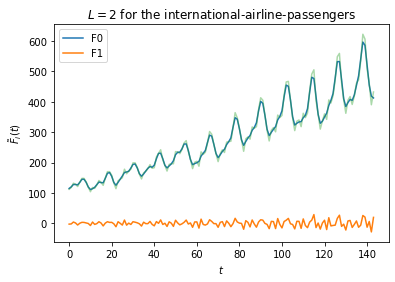

In [4]:
F_ssa_L2 = SSA(series, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the international-airline-passengers")

При длине окна 2 фактически не произошло разложение на компоненты, а только описание временного ряда. Но даже при такой длине окна высокочастотный шум отделен от временного ряда.

#### L = 5

Text(0.5, 1.0, '$L=5$ for the international-airline-passengers')

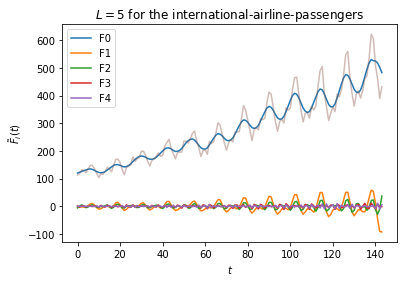

In [5]:
F_ssa_L5 = SSA(series, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the international-airline-passengers")

При длине окна 5 явные компоненты не выявлены, но компоненты уже более точно описывают временной ряд.

#### L = 20

Text(0.5, 1.0, '$L=20$ for the international-airline-passengers')

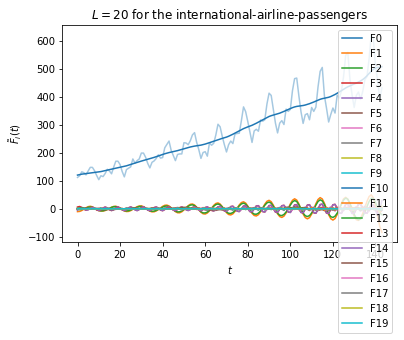

In [6]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for the international-airline-passengers")

При длине окна 20 мы начинаем видеть тренд и периодические компоненты начали обретать форму.

Рассмотрим w-корреляционную матрицу для данного окна.

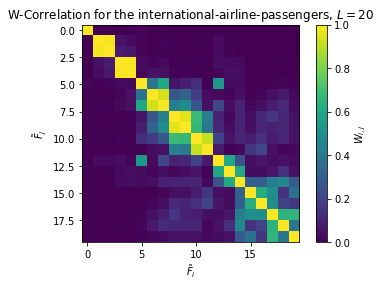

In [7]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for the international-airline-passengers, $L=20$");

w-корреляционная матрица разбита на три блока: F0, от F1 до F4 и от F5 до F19. Сгруппируем выбранные блоки и построим для них график.

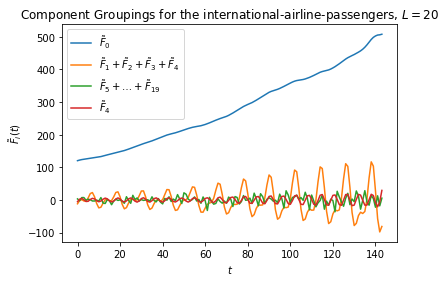

In [8]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1, 2, 3, 4]).plot()
F_ssa_L20.reconstruct(slice(5, 20)).plot()
F_ssa_L20.reconstruct(4).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the international-airline-passengers, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_4$"]);

F0 выглядит как тренд. Группа от F1 до F4 красивая периодичность. Компонент F4 вызывает беспокойство, так как выглядит так, как будто он вносит свой вклад как в шум, так и в периодичность. Это говорит о том, что нам нужно увеличить длину окна и посмотреть, получим ли мы улучшенное разделение шума и периодичности.

#### L = 40

Text(0.5, 1.0, '$L=40$ for the international-airline-passengers')

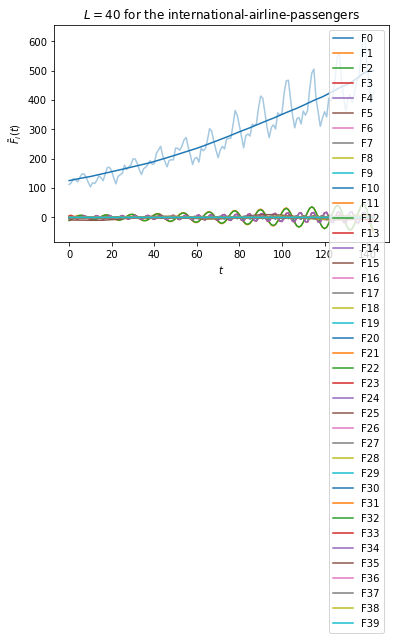

In [9]:
F_ssa_L40 = SSA(series, 40)
F_ssa_L40.components_to_df().plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=40$ for the international-airline-passengers")

При длине окна 20 линия тренда стала более гладкой.

Рассмотрим w-корреляционную матрицу для данного окна.

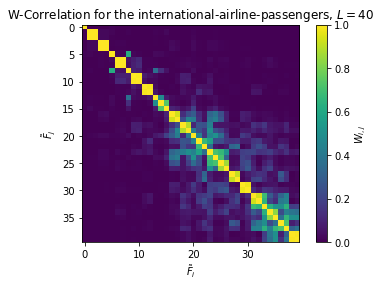

In [10]:
F_ssa_L40 = SSA(series, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for the international-airline-passengers, $L=40$");

Разделим компоненты на группы и визуализируем результат.

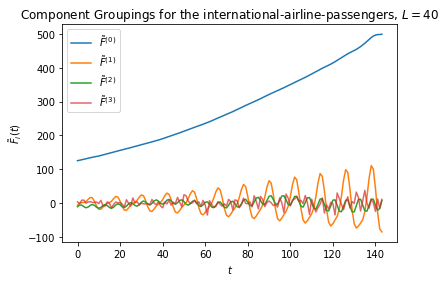

In [11]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Component Groupings for the international-airline-passengers, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

При величине окна 40 компонент тренда F0 начал перегибаться в конце временного ряда. Попробуем улучшить разделение компонент при помощи увеличения окна.

#### L = 60

Строим w-корреляционную матрицу.

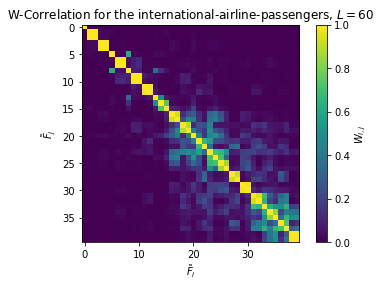

In [12]:
F_ssa_L60 = SSA(series, 40)
F_ssa_L60.plot_wcorr()
plt.title("W-Correlation for the international-airline-passengers, $L=60$");

Разделим компоненты на группы для отделения шума и визуализируем результат.

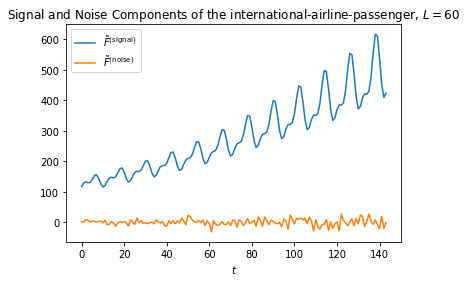

In [13]:
F_ssa_L60.reconstruct(slice(0,5)).plot()
F_ssa_L60.reconstruct(slice(7,60)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of the international-airline-passenger, $L = 60$")
plt.xlabel(r"$t$");

Рассмотрим w-корреляционную матрицу для компонентов 0-6.

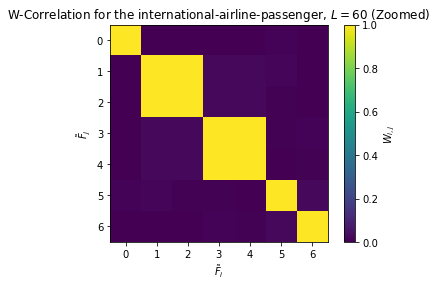

In [14]:
F_ssa_L60.plot_wcorr(max=6)
plt.title("W-Correlation for the international-airline-passenger, $L=60$ (Zoomed)");

Для доказательства отсутствия корреляции между первыми компонентами построим их графики.

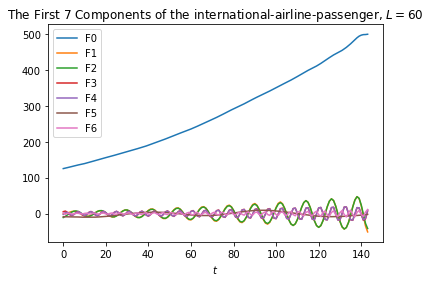

In [15]:
F_ssa_L60.components_to_df(n=7).plot()
plt.title(r"The First 7 Components of the international-airline-passenger, $L=60$")
plt.xlabel(r"$t$");

Чтобы адекватно отделить компоненты, лежащие в основе периодичности, от общего тренда требуется большая длина окна. Некоторые методы проб и ошибок необходимы, но часто легко начать с "достаточно большой" длины окна и работать оттуда. Как видно из полученных нами графиков, при слишком маленькой длине окна шум и периодичность отделяются недостаточно хорошо.